In [ ]:
# https://qdrant.tech/documentation/quick-start/
# https://qdrant.tech/documentation/tutorials/create-snapshot/
# https://qdrant.tech/documentation/guides/installation/
# https://qdrant.tech/documentation/guides/security/

# https://github.com/merveenoyan/siglip
# https://huggingface.co/visheratin/nllb-clip-base-siglip
# https://huggingface.co/visheratin/nllb-siglip-mrl-base
# https://huggingface.co/blog/fine-tune-clip-rsicd
# https://huggingface.co/merve

### Demo siglip with qdrant

In [1]:
# load the environment variables and the required libraries
import os
import uuid
from dotenv import load_dotenv
import requests
import torch
from PIL import Image
from transformers import AutoProcessor, SiglipModel, AutoTokenizer
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct

load_dotenv()

qdrant_cloud_key =  os.getenv("QDRANT_CLOUD_KEY")
qdrant_local_key = os.getenv("QDRANT_LOCAL_KEY")
hf_key = os.getenv("HF_KEY")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/var/lib/storage/miniconda3/envs/mlopsM1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the model and the tokenizer
model = SiglipModel.from_pretrained("nielsr/siglip-base-patch16-224").to(device)
processor = AutoProcessor.from_pretrained("nielsr/siglip-base-patch16-224")
tokenizer = AutoTokenizer.from_pretrained("nielsr/siglip-base-patch16-224")

In [3]:
# get the image from the url
headers = {"Authorization": f"Bearer {hf_key}"}
API_URL = "https://datasets-server.huggingface.co/rows?dataset=huggan/wikiart&config=default&split=train&offset=1&length=100"


def query():
    response = requests.get(API_URL, headers=headers)
    return response.json()


data = query()
len(data["rows"])  # 100 images

100

In [88]:
data["rows"][0]

{'row_idx': 1,
 'row': {'image': {'src': 'https://datasets-server.huggingface.co/cached-assets/huggan/wikiart/--/d559852d2b232e0fcf195e775866964f0564f2b5/--/default/train/1/image/image.jpg?Expires=1719916548&Signature=btCcyUPTMSrOfEFu2QhCQqI-HvUC2RH4RUVS0QzGH18nIlWnprmD9-FPEKlQ6kxUZPkQBxiP3dXRbrrWGKX6UDB~ku-8fKBQjAb~vI72FNy1fz9tref6jYHtfBbNL9lZXy4l-2iPryOBlf1UZgEZnKMtO-OfIBM7RnAsOgv9jhrIEY3PfD3Tgpjp~nx2jSIr18h3mhm3fWHUFCDw6~IkCmilqkXUKO1RxyTGulZjYcG3XcUYT~fjm2CxMDo0~22Abfn16Li8MtHc349unIrWXssN9hbD546iF0wHOWbI9ERBb2GNCDBtgeGzGGMf~T2fC9ZxLSxJSgnMn~ThZ~rtDw__&Key-Pair-Id=K3EI6M078Z3AC3',
   'height': 1659,
   'width': 1382},
  'artist': 20,
  'genre': 7,
  'style': 4},
 'truncated_cells': []}

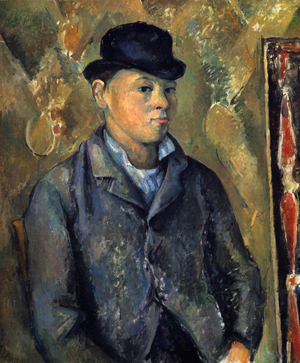

In [91]:
# display the image
url = data["rows"][1]["row"]["image"]["src"]
image = Image.open(requests.get(url, stream=True).raw)
# images are way too large that make this notebook too large as well
# downscale
width = 300
ratio = width / float(image.size[0])
height = int((float(image.size[1]) * float(ratio)))
img = image.resize((width, height), Image.Resampling.LANCZOS)
display(img)

In [4]:
client = QdrantClient(url="http://localhost:6333", api_key=qdrant_local_key)

/var/lib/storage/miniconda3/envs/mlopsM1/lib/python3.10/site-packages/qdrant_client/qdrant_remote.py:130: UserWarning: Api key is used with an insecure connection.
  warnings.warn("Api key is used with an insecure connection.")


In [ ]:
# create a collection
client.create_collection(
    collection_name="test_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

In [6]:
def add_vector(client, embedding, row_idx):
    '''
    Add the vector to the collection
    '''
    # default datatype for vectors is float32
    id = str(uuid.uuid4())
    operation_info = client.upsert(
        collection_name="test_collection",
        wait=True,
        points=[
            PointStruct(id=id, vector=embedding, payload={"row_idx": row_idx}),
        ],
    )

    print(operation_info)


def embed_siglip(image):
    '''
    Embed the image using the Siglip model
    '''
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features.detach().cpu().numpy().squeeze()

In [ ]:
# embed the image and add it to the collection
for elem in data["rows"]:
    url = elem["row"]["image"]["src"]
    image = Image.open(requests.get(url, stream=True).raw)
    feature = embed_siglip(image)
    add_vector(client, feature, elem["row_idx"])

In [9]:
prompt = "a woman"

text_token = tokenizer([prompt], return_tensors="pt").to(device)
text_features = model.get_text_features(**text_token)

text_features = np.float32(text_features.detach().cpu().numpy().squeeze())

results = client.query_points(collection_name="test_collection", query=text_features, limit=3)

In [10]:
results

QueryResponse(points=[ScoredPoint(id='4557a486-60ba-4c42-b085-bbfa835ae1ad', version=50, score=-0.0009491993, payload={'row_idx': 51}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='4813734c-1828-460a-b5c2-2cb772db0e87', version=118, score=-0.002777923, payload={'row_idx': 19}, vector=None, shard_key=None, order_value=None), ScoredPoint(id='be660be0-9504-4874-ba88-6f328b41d5ff', version=18, score=-0.002777934, payload={'row_idx': 19}, vector=None, shard_key=None, order_value=None)])

In [82]:
results.points[1].payload

{'row_idx': 26}

In [11]:
row_idxs = [results.points[i].payload["row_idx"] for i in range(3)]

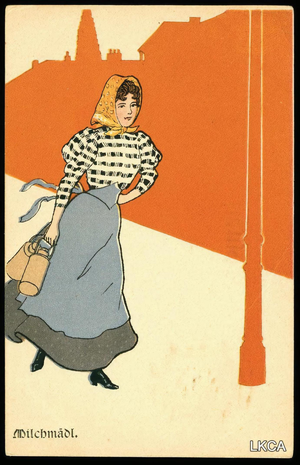

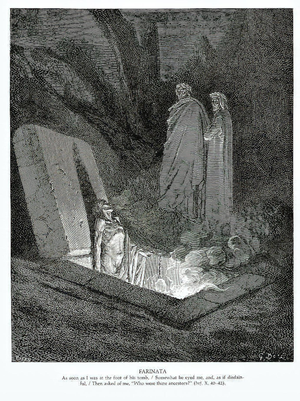

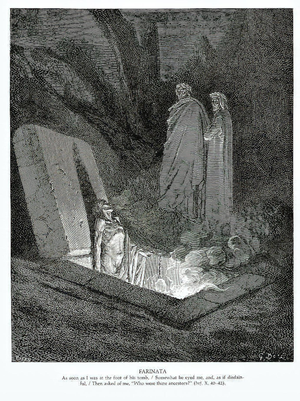

In [12]:
for elem in row_idxs:
    url = data["rows"][elem-1]["row"]["image"]["src"]
    image = Image.open(requests.get(url, stream=True).raw)

    # downscale
    width = 300
    ratio = width / float(image.size[0])
    height = int((float(image.size[1]) * float(ratio)))
    img = image.resize((width, height), Image.Resampling.LANCZOS)
    display(img)

In [99]:
# image of a man
url = "https://as1.ftcdn.net/v2/jpg/01/21/37/54/1000_F_121375466_Mmy3aq1cZjWaN7G67HOhZd2I8MXaJ4cW.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [101]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt").to(device)
    image_features = model.get_image_features(**inputs)
    image_features = image_features.detach().cpu().numpy().squeeze()

results = client.query_points(
    collection_name="test_collection", query=image_features, limit=3
)

In [103]:
row_idxs = [results.points[i].payload["row_idx"] for i in range(3)]

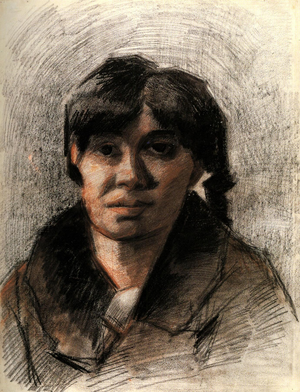

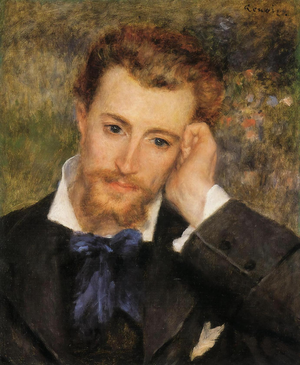

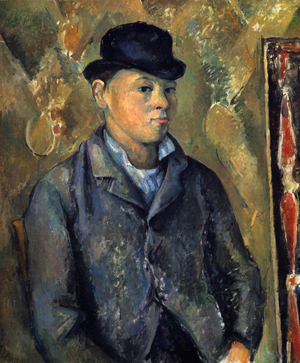

In [104]:
for elem in row_idxs:
    url = data["rows"][elem - 1]["row"]["image"]["src"]
    image = Image.open(requests.get(url, stream=True).raw)

    # downscale
    width = 300
    ratio = width / float(image.size[0])
    height = int((float(image.size[1]) * float(ratio)))
    img = image.resize((width, height), Image.Resampling.LANCZOS)
    display(img)